# Project: Write a Data Science Blog Post

## Business Understanding

There are more than 150 different crude oil grades traded in the international market. The relative value of each crude oil depends on its quality and the crude oil assay is the standard document used by the industry where the quality parameters are described for each grade.

Crude assays are usually published by oil companies that operate or are shareholders of oil fields where the corresponding crude are produced. They provide a combination of physical and chemical data that uniquely describe or characterize a crude oil and allow for the evaluation of quality parameters.

With this project, crude oil grades traded in the international oil market can be compared to evaluate the relative differences in the main parameters that define its quality and value. This type of comparison is the first step usually taken by traders and refineries to decide which grade will fit better on their economic and operational objectives.

For this project, crude oil data is gathered from the websites of selected oil companies. After being treated, the dataset is saved on a csv file. For the data modelling, the k-nearest algorithm is used for regression and assess the relative distance of a k number of crude oil grades compared with a grade used as reference. With this method, we will find the answers for the following questions from the dataset:

1. Given a certain crude oil grade, what is its best substitute?

2. What are the main differences between two crude oil benchmarks?

3. What are the 15 more expensive crude oil grades?

The comparison method will focus on three main crude oil parameters from the crude assays: API gravity, Sulphur content and Total Acidity Number. Our blog published at Medium, contains more contextual information about this topic.

## Data Understanding
    
The two types of information included in a typical crude oil assay are **bulk properties** (also known aa Whole Crude Properties) and **fractional properties** (also known as Cut Properties or composition for a specific boiling point).

The bulk quality properties of crude assays are commonly used by traders and refineries on the first step they take to classify crude oil grades. Among the bulk properties, the most prevalent are the API (American Petroleum Institute) gravity number, which is related with the density, and the Sulphur content of the crude oil which basically defines the crude relative purity. Another third parameter that is relevant for most of the refineries is the level of acidity, measured by the Total Acid Number (TAN).

To access the data, several websites, where crude oil assays are published, were analysed to define the automation process that could be suitable to extract the desired information and at the same time clean and prepare the data.

Functions 1 to 13 defined below will allow the scrapping of a selected website to download the data from several crude oil assays and save it in a csv file.

In [1]:
# === Imports and initialization ===
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from random import randint
import colorsys 
import os
import time
from os import listdir
from os.path import isfile, join
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import json
from itertools import filterfalse
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import awoc
# Initialize the AWOC class.
my_world = awoc.AWOC()

/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# == Function 1 ==
def download_file(url, linkpartial, company, download_dir):        
    ''' This function dowloads files from a given website.
        
        ARGUMENTS:
            url: url for the website to read.
            linkpartial: name and extension of the file to be downloaded.
            company: company name.
            download_dir: local directory where the file will be saved.
    '''
    # Check if folder /data/assays/company exist
    # create folder if not exist
    if os.path.exists(download_dir) != True:
        os.mkdir(download_dir)

    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    options.add_experimental_option("prefs", {
        "download.default_directory": download_dir,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "plugins.always_open_pdf_externally": True
    })
    driver = webdriver.Chrome(options=options)
    print('Downloading file to disk')
    print('THIS IS THE URL: ', url)
    driver.get(url)
    time.sleep(5)
    driver.close()
    #filePath = download_dir + linkpartial
    print('\tDone')

    return

In [3]:
# == Function 2 ==
def read_website(url):
    ''' This function read a webpage and returns its content.
    
        ARGUMENTS:
            url: url for the website to read 
    '''
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-extensions')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    
    content = driver.page_source
    webcontent = BeautifulSoup(content, 'html5lib')

    time.sleep(5)
    driver.close()

    return webcontent

In [4]:
# == Function 3 ==
def get_fileslist(url, filetype):
    ''' This function reads a webpage and returns a list with the
        the files contained on the page.
        
        ARGUMENTS:
            url: website url to read
            filetype: file extension to be retrieved
    '''

    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-extensions')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    files_list = []
    
    content = driver.page_source
    webcontent = BeautifulSoup(content, 'html5lib')
    
    elems = driver.find_elements(By.TAG_NAME, "a")
    for elem in elems:
        #print(elem)
        link = elem.get_attribute('href')
        if link is not None:
            if '/' in link and filetype in link:
        #        link = link.split('/')
        #        targetItem = link[len(link)-1]
                files_list.append(link)

    time.sleep(0.5)
    driver.close()

    return files_list

In [5]:
# == Function 4 ==
def find_value_indice(value, qlist):
    ''' This function check a given list and returns the
        index for a given value.
        
        ARGUMENTS:
            value: element to be found 
            qlist: list of elements
    '''
    charlist = value.split(' ')
    idx = -1
    check = False
    for elem in qlist:
        idx += 1
        #====================
        for item in charlist:
            if item in elem:
                check = True
            else:
                check = False
                break # finish inner loop
        #=====================
        if check == True:
            break # finish outer loop
    return check, idx

In [6]:
# == Function 5 ==
def check_tag(dfColumn, tag):
    ''' This function check a dataframe contains a given tag value.
        Returnd TRUE if the tag is found.
        
        ARGUMENTS:
            dfColumn: df column 
            tag: element to be found
    '''
    charlist = tag.split(' ')
    for item in charlist:
        if dfColumn.str.contains(item):
            # do nothing
            check = True
        else:
            check = False
            break
    
    return check

In [7]:
# == Function 6 ==
def splitTags(tag):
    charlist = tag.split(' ')
    splitted = []
    for item in charlist:
        splitted.append(item)
        
    return splitted

In [8]:
# == Function 7 ==
def get_parameters(df, tags_list):
    ''' This function extracts selected values from a data frame and 
        returns a dictionary with key/value pairs representing the values 
        extracted based on the tag list.
        
        ARGUMENTS:
            df: dataframe
            tags_list: list of tags
    '''
    result = {}
    col_list = df.columns
    
    for col_name in col_list:
        
        try:
            df[col_name] = df[col_name].str.strip()
        except AttributeError:
            pass
        
        for tag in tags_list:
            searchfor = splitTags(tag)
            
            df = df.astype(str)
            converted = df[df[col_name].str.contains('|'.join(searchfor))]
            row_lists = converted.values.tolist()
            
            cleanedList = []
            if len(row_lists) > 0:
                for nlist in row_lists:
                     # cleanedList = row_list[0]
                    try:
                        # remove 'nan' from the list
                        cleanedList.append([*filterfalse(lambda i: i == 'nan', nlist)])

                    except ValueError:
                        continue

            if len(cleanedList) > 0:
                for rlist in cleanedList:
                    check, val_index = find_value_indice(tag, rlist)
                    if check:
                        # get the value which is one position after the value label in the list
                        result[tag] = rlist.pop(val_index + 1)
                        break
        
    return result

In [9]:
# == Function 8 ==
def read_assay(url, mfile_path, tags_list):
    ''' This function reads an assay file and returns a dictionary with
        the retrieved parametes, based on a list of tags.
        
        ARGUMENTS:
            url: file url
            mfile_path: file path on the local disk 
            tags_list: list of tags
    '''
    
    print('This is the path to read: ', mfile_path)
    
    df = pd.read_excel(mfile_path, header=None, index_col=None)
    nrcolumns = len(df.columns)
    name_columns = [str(x) for x in range(0, nrcolumns)]
    df.columns = name_columns
    dic_parameters = get_parameters(url, df, tags_list)
        
    return dic_parameters

In [10]:
# == Function 9 ==
def format_output_totalenergies(parameters, grade, url, filePath):
    ''' This function adjust the data format based on the file structure 
        retrieved from Totalenergies website.
        
        ARGUMENTS:
            parameters: list of parameters
            grade: grade name
            url: website url
            filepath: file path on the local disk
    '''
    try:
        country_data = my_world.get_country_data(parameters['Country'])
        continent_name = country_data['Continent Name']
    except NameError:
        continent_name = ''

    try:
        grade['Crude'] = parameters['Crude']
    except KeyError: # could not find the crude name in the file, will use file name
        fname = filePath.split('/')
        fname = fname[len(fname) - 1].split('.')
        fname = fname[len(fname) - 2]
        parameters['Crude'] = fname

    try:
        grade['Assay Date'] = parameters['Assay']
    except KeyError: # could not find the crude name in the file, will use file name
        parameters['Assay'] = ''

    grade['Crude'] = parameters['Crude']
    grade['Assay Date'] = parameters['Assay']
    grade['API'] = parameters['° API']
    grade['Sulphur'] = parameters['Sulphur wt']
    grade['Tan (mgKOH/g)'] = parameters['Acidity mg KOH/g']
    grade['Country'] = parameters['Country']
    grade['Pour Point, °C'] = parameters['Pour Point']
    grade['Source'] = url
    grade['Region'] = continent_name

    return grade

In [11]:
# == Function 10 ==
def format_output_bp(parameters, grade, url, filePath):
    ''' This function adjust the data format based on the file structure 
        retrieved from BP website.
        
        ARGUMENTS:
            parameters: list of parameters
            grade: grade name
            url: website url
            filepath: file path on the local disk
    '''
    try:
        country_data = my_world.get_country_data(parameters['Origin:'])
        continent_name = country_data['Continent Name']
    except NameError:
        continent_name = ''

    try:
        grade['Assay Date'] = parameters['Sample Date:']
    except KeyError: # could not find the crude name in the file, will use file name
        parameters['Sample Date:'] = ''

    grade['Crude'] = parameters['Name:']
    grade['Assay Date'] = parameters['Sample Date:']
    grade['API'] = parameters['Gravity API']
    grade['Sulphur'] = parameters['Total Sulphur']
    grade['Tan (mgKOH/g)'] = parameters['Acidity (mgKOH/g)']
    grade['Country'] = parameters['Origin:']
    grade['Pour Point, °C'] = parameters['Pour Point']
    grade['Source'] = url
    grade['Region'] = continent_name

    return grade

In [12]:
# == Function 11 ==
def format_output_exxon(parameters, grade, url, filePath):
    ''' This function adjust the data format based on the file structure 
        retrieved from Exxon website.
        
        ARGUMENTS:
            parameters: list of parameters
            grade: grade name
            url: website url
            filepath: file path on the local disk
    '''
    
    fname = filePath.split('/')
    fname = fname[len(fname) - 1].split('assay')
    fname = fname[0].split('_')
    crude_name = ''
    for word in fname:
        crude_name += word + ' '
    parameters['Name:'] = crude_name.replace('Crude Oil ', '').strip().upper()
    
    grade['Crude'] = parameters['Name:']
    grade['Assay Date'] = ''
    grade['API'] = parameters['Gravity API']
    try:
        grade['Sulphur'] = parameters['Sulfur wt%']
    except KeyError:
        grade['Sulphur'] = ''
        
    try:
        grade['Tan (mgKOH/g)'] = parameters['Neutralization number (TAN)']
    except KeyError:
        grade['Tan (mgKOH/g)'] =''
        
    grade['Country'] = ''
    
    try:
        grade['Pour Point, °C'] = parameters['Pour point']
    except KeyError:
        grade['Pour Point, °C'] = ''
        
    grade['Source'] = url
    grade['Region'] = ''
    
    return grade

In [13]:
# == Function 12 ==
def format_output_equinor(parameters, grade, url, filePath):
    ''' This function adjust the data format based on the file structure 
        retrieved from Equinor website.
        
        ARGUMENTS:
            parameters: list of parameters
            grade: grade name
            url: website url
            filepath: file path on the local disk
    '''
    try:
        country_data = my_world.get_country_data(parameters['Origin:'])
        continent_name = country_data['Continent Name']
    except NameError:
        continent_name = ''

    grade['Crude'] = parameters['Traded Crude:']
    grade['Assay Date'] = parameters['Assay Date:']
    grade['API'] = parameters['API Gravity']
    grade['Sulphur'] = parameters['Total Sulphur']
    grade['Tan (mgKOH/g)'] = parameters['Total Acid Number']
    grade['Country'] = parameters['Origin:']
    grade['Pour Point, °C'] = parameters['Pour Point']
    grade['Source'] = url
    grade['Region'] = continent_name
    
    return grade

In [14]:
# == Function 13 ==
def main_get_grades(url, sourcelist, filetype, company, query, download_files=True):
    ''' This is the main function that starts the process to retrieve the data.
        
        ARGUMENTS:
            url: website url
            sourcelist: list of source file names
            filetype: type of file to read
            company: company name
            query: list of parameters to retrieve
            parameters: list of parameters
            download_files: TRUE if files will be downloade, FALSE if files were
                            previously downloaded
    '''
    grades = []
    flist = []
    count = 1
    download_dir = os.getcwd() + '/data/crude_assays/' + company + '/'
    for link in sourcelist:
        if link is not None:
            if '/' in link and filetype in link:
                link = link.split('/')
                targetItem = link[len(link)-1]
                flist.append(targetItem)
                
    totalCount = len(flist)
    
    if download_files == True:
        # === download assay files ===
        for (linkpart, source) in zip(flist, sourcelist):
            #grade = {}
            print("Processing file %2d of %2d ..." % (count, totalCount))
            #soup = read_website(url)
            download_file(source, linkpart, company, download_dir)
            count += 1

    # === read assay files ===
    fileslist = [f for f in listdir(download_dir) if isfile(join(download_dir, f))]
    totalCount = len(fileslist)
    count = 1
    for (mfile, source) in zip(fileslist, sourcelist):
        grade = {}
        print("Reading assay file %2d of %2d ..." % (count, totalCount))
        filePath = join(download_dir, mfile)
        parameters = read_assay(url, filePath, query)
        
        #print('THESE ARE PARAMETERS:', parameters)
        
        if company == 'totalenergies':
            grade = format_output_totalenergies(parameters, grade, url, filePath)
         
        if company == 'bp':
            grade = format_output_bp(parameters, grade, url, filePath)
            
        if company == 'exxon':
            grade = format_output_exxon(parameters, grade, url, filePath)
            
        if company == 'equinor':
            grade = format_output_equinor(parameters, grade, url, filePath)
        
        grades.append(grade)
        count += 1
        # print('THESE ARE GRADES:', grades)
        
    return grades

### Variable definitions for data collection

On the blocks below are defined the variables for selected oil companies. The chosen approach to collect the data from the internet is designed to use just one company at a time. The preliminary result will be saved on csv file containing the name of the company.

In [15]:
# == PREPARE DATA FOR COMPANY 1 ==
company_name = 'totalenergies'
url = "https://ts.totalenergies.com/business-customers/crude-assays/"
file_type = '.xlsx'
query_list = ['Crude',
              '° API',
              'Sulphur wt',
              'Acidity mg KOH/g', 
              'Country', 
              'Pour Point',
              'Assay']

flist = get_fileslist(url, file_type)
final_results = main_get_grades(url, flist, file_type, company_name, query_list, download_files=False)
ndf = pd.DataFrame(final_results)
wdir = os.getcwd() + '/data/crude_assays/assays_summary/'
ndf.to_csv(wdir + 'summary_crude_assays_' + company_name + '.csv', index=False)

In [16]:
# == PREPARE DATA FOR COMPANY 2 ==
company_name = 'bp'
url = "https://www.bp.com/en/global/bp-trading-and-shipping/documents-and-downloads/technical-downloads/crudes-assays.html"
file_type = '.xls'
query_list = ['Name:',
             'Sample Date:',
             'Gravity API',
             'Total Sulphur',
             'Acidity (mgKOH/g)', 
             'Origin:', 
             'Pour Point']

flist = get_fileslist(url, file_type)    
final_results = main_get_grades(url, flist, file_type, company_name, query_list, download_files=False)
ndf = pd.DataFrame(final_results)
wdir = os.getcwd() + '/data/crude_assays/assays_summary/'
ndf.to_csv(wdir + 'summary_crude_assays_' + company_name + '.csv', index=False)

In [17]:
# == PREPARE DATA FOR COMPANY 3 ==
company_name = 'exxon'
url = "https://corporate.exxonmobil.com/Crude-oils/Crude-trading/Assays-available-for-download"
file_type = '.xlsx'
query_list = ['Gravity API',
             'Sulfur wt%',
             'Neutralization number (TAN)', 
             'Pour point']

flist = get_fileslist(url, file_type)
final_results = main_get_grades(url, flist, file_type, company_name, query_list, download_files=False)
ndf = pd.DataFrame(final_results)
wdir = os.getcwd() + '/data/crude_assays/assays_summary/'
ndf.to_csv(wdir + 'summary_crude_assays_' + company_name + '.csv', index=False)

In [18]:
# == PREPARE DATA FOR COMPANY 4 ==
company_name = 'equinor'
url = "https://www.equinor.com/energy/crude-oil-assays"
file_type = '.xlsx'
query_list = ['Traded Crude:',
              'Origin:',
              'Assay Date:',
              'API Gravity',
             'Total Sulphur',
             'Total Acid Number', 
             'Pour Point']

flist = get_fileslist(url, file_type)
if company_name == 'equinor': # need to exclude the link for the Equinor's summary file
    newList = [item for item in flist if "quality-overview-equinor-crudes" not in item]
    flist = newList
    
final_results = main_get_grades(url, flist, file_type, company_name, query_list, download_files=False)
ndf = pd.DataFrame(final_results)
wdir = os.getcwd() + '/data/crude_assays/assays_summary/'
ndf.to_csv(wdir + 'summary_crude_assays_' + company_name + '.csv', index=False)

## Data Preparation

After running the cells above, the cell below will join the summary data of existing companies in just one file that will be used as the master dataset for the modelling and evaluation stages.

In [2]:
# == JOIN ALL COMPANY DATA IN ONE FILE ==
wdir = os.getcwd() + '/data/crude_assays/assays_summary/'
fileslist = [f for f in listdir(wdir) if isfile(join(wdir, f))]
df_list = []
for mfile in fileslist:
    df_list.append(pd.read_csv(join(wdir,mfile)))

result = pd.concat(df_list)

result.to_csv(wdir + 'master_crude_20220916.csv', index=False)

NOTE: The following stages require the master dataset file ready to be used, after completion of the steps defined and described above. With this notebook I am providing the *master_crude_data.csv* file that was created as per above procedure. I did some additions manually, for additional cleaning and using data found on other sources and publications. Nevertheless, the steps above demonstrate the different steps and ways performed for scrapping the data, directly from a webpage or from a file that can be downloaded.

## Data Modelling

The function *getneighbor_grades* receive the necessary arguments and after being adjusted, the data and corresponding parameters will be applied to the NearestNeighbors data model. The NearestNeighbors model is imported from the Scikit-Learn data science library. That model is based on the Euclidian space calculations that are applied for data regression and classification. 

In [16]:
def getneighbor_grades (crude_data_df, reference_grade, countries, quality_criteria, k=5):
    ''' This function, prepares the data and headings, set the
    model and perform the predictions
    
    Arguments
        reference_grade: reference grade name;
        countries: is a list with the selected countries to be used as reference for
            the grades comparison.
        quality_criteria: list with the selected crude quality criteria;
        k: number of nearest grades to be returned, including the reference grade as 1st item

    Return:
        1. a list of lists with the data of the k nearest grades found
        2. a list of the grades eligible for comparison
    '''
    
    # Get the parameters that will be used for the comparison
    limit =  len(quality_criteria)
    listParameters = []
    col_names = ['Crude']
    for i in range(0, limit):
        if quality_criteria[i] == 'SULPHUR':
            listParameters.append('Sulphur (%)')
            col_names.append('Sulphur (%)')

        elif quality_criteria[i] == 'TAN':
            listParameters.append('Tan (mgKOH/g)')
            col_names.append('Tan (mgKOH/g)')            
        
        else:
            listParameters.append(quality_criteria[i])
            col_names.append(quality_criteria[i])

    # include additional columns
    col_names.append('Country')
    col_names.append('Notes')
    
    df1 = crude_data_df[col_names]


    if 'Tan (mgKOH/g)' in df1.columns:
        #Remove the rows containing NaN in the TAN column
        df2 = df1[df1['Tan (mgKOH/g)'].notna()]
        df2.reindex()
    else:
        df2 = df1

    results = []

    #Prepare the items for the reference grade
    ref_grade = df2.loc[df2['Crude'] == reference_grade]
    ref_param = ref_grade[listParameters].values.tolist()
    
    #Filter the sample grades using the selected reference countries
    df2 = df2.loc[df2['Country'].isin(countries)]

    #In case the country of the reference grade is not chosen for the selection
    #criteria, all the data of the reference grade need to be added back into the
    #filtered dataframe (otherwise it will note be shown in the results)!
    if ref_grade['Country'].iloc[0] not in countries:
        df2 = df2.append(ref_grade)

    # Take the values of all the existing grades for training, excluding the label, 
    # which is a string
    samples = df2[listParameters].values.tolist()

    # Need to verify that the sample size is bigger than k
    if len(samples) < k:
        k = len(samples)

    # Apply the K NearestNeighbors model
    neigh = NearestNeighbors(n_neighbors=k)
    # Train the model
    neigh.fit(samples)
    # Find the nearest elements to the reference grade
    distance, indices = neigh.kneighbors(ref_param)
    nGrade_values = []

    # add the grades on the results list
    for i in indices[0]:
        nGrade_values = df2.iloc[i].values.tolist()
        results.append(nGrade_values)
 
    #If the reference_grade is not the 1st in the list, then move its position
    #This may be required when reindex is used above
    if results[0][0] != reference_grade:
        for i in range(len(results)):
            if results[i][0] == reference_grade:
                temp = results[i]
                results.remove(temp)
                results.insert(0, temp)

    #Insert the ranking value for the 'Ranking' column
    for i in range(len(results)):
        results[i].insert(0, i)
        
    # update the table header
    col_names.insert(0, 'Ranking')
    
    return results, col_names

In [17]:
def figures_data (results, headings):
    """ Prepare the results to be used for the chart(s).
    Args
        results: A list with the result values
        headings: A list with the result headings for the table
    Returns
        resList: A list of dictionaries with the corresponding values for each grade
    """
    
    resList = []

    for grade in results:
        temp_dic = { }        
        for item in headings:
            if 'Crude' in item:
                temp_dic['Crude'] = grade[headings.index('Crude')]
            if 'API' in item:
                temp_dic['API'] = grade[headings.index('API')]
            if 'Sulphur (%)' in item:
                temp_dic['Sulphur (%)'] = grade[headings.index('Sulphur (%)')]
            if 'TAN' in item:
                temp_dic['TAN'] = grade[headings.index('TAN')]

        resList.append(temp_dic)

    return resList

In [18]:
def get_figures_mpl(df, features, nrGrades):
    """ Creates visualizations using Matplotlib 

    Args
        df: A pandas dataframe with the data to plot;
        features: List of features to extract;
        nrGrades: Nr of points to display;

    Returns
        fig: list containing plotly visualizations
    """
    mpl_colors = ['red', 'rosybrown', 'maroon', 'chocolate', 'tomato', 'navy', 
                  'blue', 'plum', 'magenta', 'violet', 'green', 'lime', 
                  'mediumaquamarine', 'aquamarine', 'cyan', 'orange', 'oldlace', 
                  'tan', 'khaki', 'lightyellow', 'indigo', 'yellow', 'black', 'gray', 'lightgrey']

    nrFeatures = len(features)    
    
    if nrFeatures == 1:
        fig = plt.figure(figsize=(10, 5))
        x_names = df['Crude'].tolist()
        N = len(x_names)
        freq_x = 1
        xs = np.arange(N)
        ys = df[features[0]].tolist()
        plt.bar(xs, ys, 
                width=1, 
                color=mpl_colors, 
                edgecolor="white", 
                tick_label=x_names,
                linewidth=0.7)
        plt.xticks(np.arange(0, N, freq_x))
        plt.xticks(rotation = 45)
        plt.xlabel('Crude')
        plt.ylabel(features[0])
        
    if nrFeatures == 2:
        fig = plt.figure(figsize=(10, 5))
        x_names = df['Crude'].tolist()
        xs = df[features[1]].values.tolist()
        ys = df[features[0]].values.tolist()
                
        for (x, y, color, crude) in zip(xs, ys, mpl_colors, x_names):
            plt.scatter(x, y, c=color, s=50, edgecolor='k', label=crude)
        
        plt.xlabel(features[1])
        plt.ylabel(features[0])
        plt.grid(True)
        l1 = plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

    if nrFeatures == 3:
        fig = plt.figure(figsize=(10, 5))
        x_names = df['Crude'].tolist()
        ax = fig.add_subplot(111, projection='3d')
        xs = df['Sulphur (%)'].values.tolist()
        ys = df['Tan (mgKOH/g)'].values.tolist()
        zs = df['API'].values.tolist()
        
        for (x, y, z, color, crude) in zip(xs, ys, zs, mpl_colors, x_names):
            ax.scatter(x, y, z, c=color, linewidth=0.5, label=crude)
        
        ax.set_xlabel('Sulphur (%)')
        ax.set_ylabel('Tan (mgKOH/g)')
        ax.set_zlabel('API')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    return fig


In [19]:
def get_figs_clusters_mpl(df):
    mpl_colors = ['red', 'rosybrown', 'maroon', 'chocolate', 'tomato', 'navy', 
                  'blue', 'plum', 'magenta', 'violet', 'green', 'lime', 
                  'mediumaquamarine', 'aquamarine', 'cyan', 'orange', 'oldlace', 
                  'tan', 'khaki', 'lightyellow', 'indigo', 'yellow', 'black', 'gray', 'lightgrey']
    
    fig = plt.figure(figsize=(10, 5))
    x_names = df['Crude'].tolist()
    xs = df['Sulphur (%)'].values.tolist()
    ys = df['API'].values.tolist()

    for (x, y) in zip(xs, ys):
        plt.scatter(x, y)
        
    plt.axhline(y=10, lw=3, linestyle = 'dashed', color='black')
    plt.axhline(y=22.3, lw=3, linestyle = 'dashed', color='green')
    plt.axhline(y=32.1, lw=3, linestyle = 'dashed', color='red')
    plt.axhline(y=42.1, lw=3, linestyle = 'dashed', color='yellow')
    plt.axvspan(-0.01, 0.5, facecolor='red', alpha=0.2)
    
    plt.text(5, 15, 'HEAVY', horizontalalignment='right', fontsize=10)
    plt.text(5, 25, 'MEDIUM', horizontalalignment='right', fontsize=10)
    plt.text(5, 35, 'LIGHT', horizontalalignment='right', fontsize=10)
    plt.text(5, 45, 'EXTRA-LIGHT', horizontalalignment='right', fontsize=10)

    plt.title("All Grades in Dataset")
    plt.xlabel('Sulphur (%)')
    plt.ylabel('API')
    plt.grid(True)

    return fig

## Evaluation

For the evaluation, the model will be used to assess 3 questions:

1. Given a certain crude oil grade, what is its best substitute?

2. What are the main differences between two crude oil benchmarks?

3. What are the 15 more expensive crude oil grades?

The input parameters will be the reference grade, the list of source countries, the list of properties and the number of grades to be compared. 

The output will be a table showing the grades ranked by proximity to the reference grade and the result can be also shown on a chart. Depending on the number of properties selected for comparison, the chart can be of 3 Dimension, 2 Dimension or 1 Dimension.

In [20]:
# Read data
workingpath = os.getcwd()
datapath = workingpath + '/data/master_crude_20220916.csv'
df_data = pd.read_csv(datapath, encoding= 'unicode_escape')

In [21]:
# Below are the lists with values that will be used as input parameters
# for the evaluations
countries = df_data['Country'].sort_values().drop_duplicates().dropna().values.tolist()
all_grades = df_data['Crude'].sort_values().drop_duplicates().dropna().values.tolist()
all_properties = ['API', 'Sulphur (%)', 'Tan (mgKOH/g)']
k_list = range(2,15)

In [22]:
print(countries)

[' Australia', 'Abu Dhabi', 'Algeria', 'Angola', 'Argentina', 'Australia', 'Australia ', 'Azerbaijan', 'Bahrain', 'Brazil', 'Brunei', 'Cameroom', 'Cameroon', 'Canada', 'Chad', 'China', 'Colombia', 'Congo', 'Denmark', 'Ecuador', 'Egypt', 'Equatorial Guinea', 'Gabon', 'Ghana', 'Guyana', 'Indonesia', 'Iran', 'Iraq', 'Jotun', 'Kazakhstan', 'Kuwait', 'Libya', 'Louisiana', 'Malaysia', 'Malaysia ', 'Mexico', 'Neutral Zone', 'New Guinea', 'Newfoundland', 'Nigeria', 'North Sea - Norway', 'North Sea - UK', 'Norway', 'Oman', 'Peru', 'QATAR', 'Qatar', 'Russia', 'Saudi Arabia', 'South Sudan', 'Sudan', 'Syria', 'Trinidad and Tobago', 'UAE', 'USA', 'United Arab Emirates', 'United Kingdom', 'Venezuela', 'Vietnam', 'Yemen']


In [23]:
print(all_grades)

['Agbami', 'Akpo Blend', 'Al Jurf', 'Al Shaheen', 'Alaskan North Slope', 'Albacora Leste', 'Algerian Condensate - Bejaia', 'Alvheim Blend (5%Vol Frosk)', 'Amenam Blend', 'Amna', 'Ans', 'Arab Extra Light', 'Arab Heavy', 'Arab Light', 'Arab Medium', 'Arab Super Light', 'Ardjuna   ', 'Asgard Blend', 'Atapu', 'Attaka', 'Azeri  Light  (Fob Ceyhan)', 'Azeri (Ceyhan)', 'Azeri Light', 'Azeri Lt/Btc - Ceyhan', 'Bach Ho   ', 'Badak', 'Bakken', 'Balder Blend', 'Banoco', 'Banyu Urip', 'Basrah', 'Basrah Heavy', 'Basrah Light', 'Basrah Medium', 'Bekapai', 'Belida   ', 'Bonga', 'Bonito', 'Bonny Light', 'Bontang Return Condensate', 'Bow River', 'Brass River', 'Brega', 'Brent Blend', 'Btc', 'Cabinda', 'Cascade Chinook Blend', 'Castilla', 'Ceiba', 'Champion', 'Cinta    ', 'Clair', 'Clov', 'Cold Lake Blend', 'Condensate Ichthys', 'Condensate Senipah', 'Condensate Snohvit', 'Condensate-Bontang-Return', 'Cossack', 'Cpc', 'Crude Oil Liza', 'Culzean', 'Curlew', 'Dalia', 'Daqing    ', 'Dar', 'Das Blend', 'Dje

In [24]:
print(all_properties)

['API', 'Sulphur (%)', 'Tan (mgKOH/g)']


In [25]:
print(k_list)

range(2, 15)


### Question 1: Given a certain crude oil grade, what is its best substitute?

Very often the refineries need to find substitutes to one particular feedstock grade. This may be required for many different reasons. For example, due to economic optimization or due to possible unavailability of the reference grade in the market. To perform the substitution assessment, the first step is to select the reference grade, then the number of grades to be compared is defined and finally the selection is adjusted by fine tuning the number of possible source countries.

For example, let’s assume we want to find the best possible substitute for the Nigerian grade Agbami, within the closest 15 grades from the dataset. Below we will look at 3 different type of results for this question 1 to illustrate the features available.

**(3D Assessment)**

For this 3D assessment, set the evaluation variables as follow:

- Ref. Grade: Select 'Agbami' (another grade can be selected if desired to be assessed)
- Countries: Select all countries
- Properties: Select all properties
- Nr. Grades: Select 15

In [26]:
# Define evaluation variables
refgrade = 'Agbami'
list_countries = countries
quality_properties = all_properties
kvalue = 15

In [27]:
# Get evaluation results
results, header = getneighbor_grades(
                df_data,
                refgrade, 
                list_countries, 
                quality_properties, 
                kvalue)

/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [28]:
# Print results table
df_result = pd.DataFrame(results, columns=header)
df_result.style.hide_index()

Ranking,Crude,API,Sulphur (%),Tan (mgKOH/g),Country,Notes
0,Agbami,47.9,0.04,0.1,Nigeria,https://www.equinor.com/energy/crude-oil-assays
1,Condensate Ichthys,48.4,0.01,0.05,Australia,https://ts.totalenergies.com/business-customers/crude-assays/
2,Tengiz,47.5,0.47,0,Kazakhstan,nan
3,Asgard Blend,48.5,0.18,0.04,Norway,https://ts.totalenergies.com/business-customers/crude-assays/
4,Cossack,48.8,0.03,0.04,Australia,https://www.bp.com/en/global/bp-trading-and-shipping/documents-and-downloads/technical-downloads/
5,Skarv,49,0.1,0.023,Norway,https://www.equinor.com/energy/crude-oil-assays
6,Akpo Blend,46.7,0.07,0.08,Nigeria,https://ts.totalenergies.com/business-customers/crude-assays/
7,Njord,46.62,0.05,0.02,Norway,https://www.equinor.com/energy/crude-oil-assays
8,Culzean,49.2,0.01,0.02,United Kingdom,https://ts.totalenergies.com/business-customers/crude-assays/
9,Belida,46.2,0.02,0,Indonesia,nan


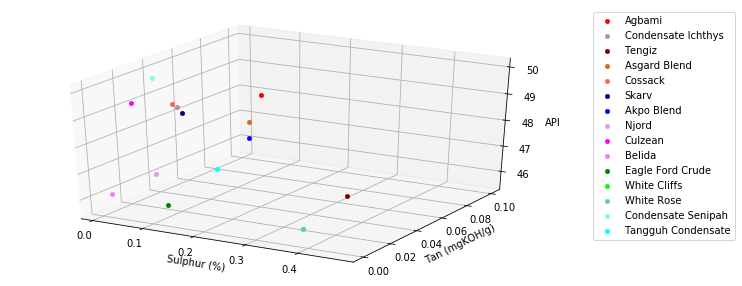

In [29]:
# Print results chart
chart = get_figures_mpl(df_result, quality_properties, kvalue)

From the ranking on the results above we can say that the 1st best substitute grade for Agbami is Asgard Blend, produced in Norway, followed in 2nd by Condensate Ichthys, produced in Australia. Because the three available quality parameters were selected, the result is also automatically plotted on a 3D chart.

From the 3D chart, it can be seen visually the relative position of the compared grades based on the parameters, API, Tan and Sulphur content. While on the ranking table Asgard Blend is ranked as the closest to Agbami, on the 3D chart Agbami is shown closer to Condensate Ichthys. This is due to the Tan value influence. On the used dataset the Tan value for some grades is unknown and it was set to zero. The 2D assessment below can provide another perspective of the results.

**(2D Assessment)**

For the 2D assessment, set the evaluation variables as follow:
- Ref. Grade: Select 'Agbami' (another grade can be selected if desired to be assessed)
- Countries: Select all countries
- Properties: **Select 'API' and 'Sulphur (%)'**
- Nr. Grades: Chose 15

In [30]:
# Define evaluation variables
refgrade = 'Agbami'
list_countries = countries
quality_properties = ['API', 'Sulphur (%)']
kvalue = 15

In [31]:
# Get evaluation results
results, header = getneighbor_grades(
                df_data,
                refgrade, 
                list_countries, 
                quality_properties, 
                kvalue)

/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [32]:
# Print results table
df_result = pd.DataFrame(results, columns=header)
df_result.style.hide_index()

Ranking,Crude,API,Sulphur (%),Country,Notes
0,Agbami,47.9,0.04,Nigeria,https://www.equinor.com/energy/crude-oil-assays
1,Condensate Ichthys,48.4,0.01,Australia,https://ts.totalenergies.com/business-customers/crude-assays/
2,Tengiz,47.5,0.47,Kazakhstan,nan
3,Asgard Blend,48.5,0.18,Norway,https://ts.totalenergies.com/business-customers/crude-assays/
4,Cossack,48.8,0.03,Australia,https://www.bp.com/en/global/bp-trading-and-shipping/documents-and-downloads/technical-downloads/
5,Skarv,49,0.1,Norway,https://www.equinor.com/energy/crude-oil-assays
6,Akpo Blend,46.7,0.07,Nigeria,https://ts.totalenergies.com/business-customers/crude-assays/
7,Njord,46.62,0.05,Norway,https://www.equinor.com/energy/crude-oil-assays
8,Culzean,49.2,0.01,United Kingdom,https://ts.totalenergies.com/business-customers/crude-assays/
9,Belida,46.2,0.02,Indonesia,nan


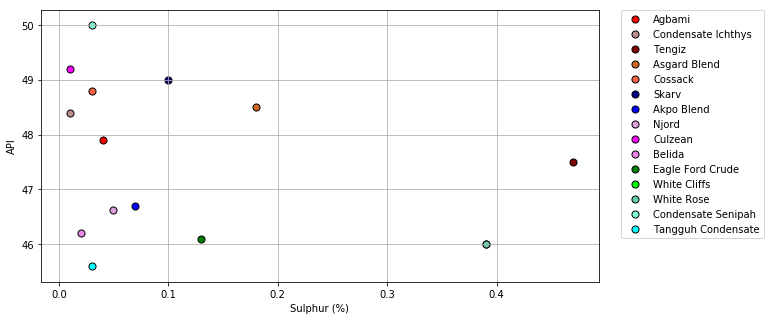

In [33]:
# Print results chart
chart = get_figures_mpl(df_result, quality_properties, kvalue)

The ranking table of the grades above is unchanged and on the 2D chart it is clearer to see the relative position of the reference grade (Agbami) and its closest substitute (Asgard Blend).

**(1D Assessment)**

For the 1D assessment, set the evaluation variables as follow:
- Ref. Grade: Select 'Agbami' (another grade can be selected if desired to be assessed)
- Countries: Select all countries 
- Properties: Select 'Sulphur (%)' (it could be one of the other 2 properties, 'API' or 'Tan (mgKOH/g)')
- Nr. Grades: Chose 15

In [34]:
# Define evaluation variables
refgrade = 'Agbami'
list_countries = countries
quality_properties = ['Sulphur (%)']
kvalue = 15

In [35]:
# Get evaluation results
results, header = getneighbor_grades(
                df_data,
                refgrade, 
                list_countries, 
                quality_properties, 
                kvalue)

/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [36]:
# Print results table
df_result = pd.DataFrame(results, columns=header)
df_result.style.hide_index()

Ranking,Crude,Sulphur (%),Country,Notes
0,Agbami,0.04,Nigeria,https://www.equinor.com/energy/crude-oil-assays
1,Gippsland Blend,0.04,Australia,https://corporate.exxonmobil.com/Crude-oils/Crude-trading/Assays-available-for-download
2,Tapis,0.04,Malaysia,https://corporate.exxonmobil.com/Crude-oils/Crude-trading/Assays-available-for-download
3,Bach Ho,0.04,Vietnam,nan
4,N'Kossa Blend,0.04,Congo,https://ts.totalenergies.com/business-customers/crude-assays/
5,Attaka,0.04,Indonesia,nan
6,Tangguh Condensate,0.03,Indonesia,https://www.bp.com/en/global/bp-trading-and-shipping/documents-and-downloads/technical-downloads/
7,Njord,0.05,Norway,https://www.equinor.com/energy/crude-oil-assays
8,Eagle Ford Condensate,0.05,USA,nan
9,Nile Blend,0.05,Sudan,nan


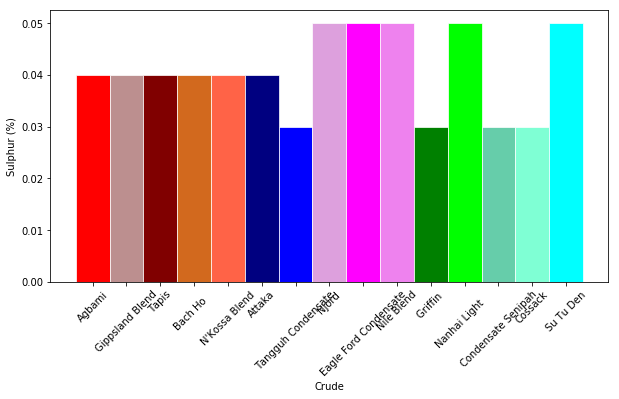

In [37]:
# Print results chart
chart = get_figures_mpl(df_result, quality_properties, kvalue)

As shown above, in terms of sulphur content, Attaka and Bach Ho are the closest grades to Agbami. These results are very different from the previous two queries. Nevertheless, it can be used to show the crudecompare dashboard feature to handle one-dimension comparisons. In fact, for the purpose of grade substitution assessment, the 1D assessment is less relevant than the 3D and 2D assesments shown earlier.

### Question 2: What are the main differences between two crude oil benchmarks?

Currently the main benchmarks for crude oil are, WTI from USA, Dated Brent from Northern Western Europe and OPEC, a basket of crude oil from different countries that are members of the Organization of Petroleum Exporting Countries (OPEC). Other Official Selling Prices (OSPs) are used in several parts of the world as localized market reference, but their pricing mechanisms are also influenced by the main benchmarks mentioned above.

For this assessment, Brent is selected as the reference grade and for countries only UK and US are selected, because they are the source countries. This will bring those two benchmarks within the range of 15 grades to compare.

Set the evaluation variables as follow:
- Ref. Grade: Select 'Brent Blend'
- Countries: Select 'US', 'USA', 'United Kingdom' and 'United States'
- Properties: Select 'API' and 'Sulphur (%')
- Nr. Grades: Chose 15

In [38]:
# Define evaluation variables
refgrade = 'Brent Blend'
list_countries = ['US', 'USA', 'United Kingdom', 'United States']
quality_properties = ['API', 'Sulphur (%)']
kvalue = 15

In [39]:
# Get evaluation results
results, header = getneighbor_grades(
                df_data,
                refgrade, 
                list_countries, 
                quality_properties, 
                kvalue)

/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [40]:
# Print results table
df_result = pd.DataFrame(results, columns=header)
df_result.style.hide_index()

Ranking,Crude,API,Sulphur (%),Country,Notes
0,Brent Blend,38.6,0.39,North Sea - UK,https://www.bp.com/en/global/bp-trading-and-shipping/documents-and-downloads/technical-downloads/
1,Lls,38.5,0.39,USA,nan
2,Niobrara,39,0.39,USA,nan
3,Wts,38,0.5,USA,nan
4,Dumbarton,40.2,0.28,United Kingdom,https://ts.totalenergies.com/business-customers/crude-assays/
5,West Texas Intermediate (Wti),40.42,0.33,USA,nan
6,Light Luisiana Sweet (Lls),36.64,0.36,USA,nan
7,Flotta Gold,36.3,0.63,United Kingdom,https://ts.totalenergies.com/business-customers/crude-assays/
8,Eugene Island,36,1.2,USA,nan
9,Domestic Sweet (Dsw),41.6,0.41,USA,nan


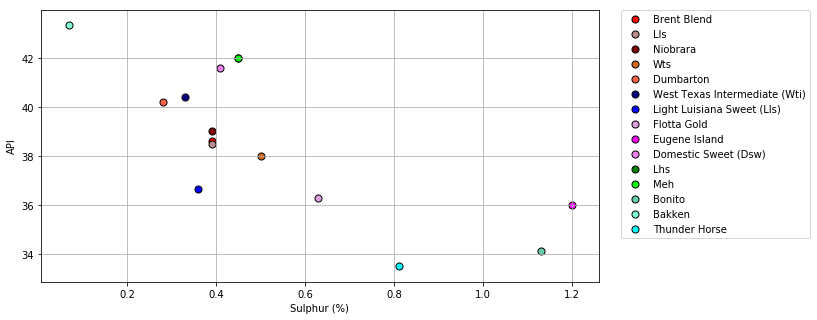

In [41]:
# Print results chart
chart = get_figures_mpl(df_result, quality_properties, kvalue)

From a direct comparison, WTI is lighter (i.e has higher API) and sweeter (i.e., with lower Sulphur content) than Brent. Just because of that, we could infer that WTI is more expensive than Brent. But, looking at the relative performance of those two benchmarks in the last five years, Brent has been valued above WTI most of the time.

This is because while WTI is mainly used by US consumers, Brent is used to price about two thirds of the crude oil traded in the global market, including grades supplied by OPEC.

Between Brent and WTI there are four other grades, namely, LLS, Niobrara, WTS and Dumbarton.

### Question 3: How to find the 15 most expensive crude oil grades

To evaluate this question, first run the function that will print the cluster chart below.

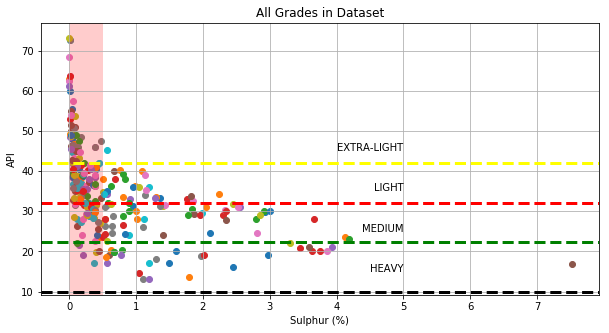

In [42]:
fig = get_figs_clusters_mpl(df_data)

On the chart above are plotted all the grades contained in the analysed dataset. Crude oils with API degree below 10 are classified as Extra-Heavy, between 10 and 22 are classified as Heavy, Medium grades are considered between 22 and 32, between 32 and 42 are Light and all above 42 are Extra-Light grades.

It is worth to note that the clear-cut definition of light and heavy crude is not uniform in all the industry. The classification is based more on practical aspects than theoretical.

Crude oil grades with high sulphur content and low API are least expensive. Based on that, we can expect to find the most valuable crude oil grades within the top side of the range shown in pink on the chart above, representing the sweet crudes range, i.e, with low sulphur content.

From a previous query (when looking for a substitute grade for Agbami), we know that Condensate Senipah is in the top range with an API of 50. So, we will use it as the reference grade to zoom in that top left corner of the dataset and look at the closest 15 grades. 

For a closer look, set the evaluation variables as follow:
- Ref. Grade: Select 'CONDENSATE SENIPAH'
- Countries: Select all countries
- Properties: Select 'API' and 'Sulphur (%')
- Nr. Grades: Chose 15

In [48]:
# Define evaluation variables
refgrade = 'Condensate Senipah'
list_countries = countries
quality_properties = ['API', 'Sulphur (%)']
kvalue = 15

In [49]:
# Get evaluation results
results, header = getneighbor_grades(
                df_data,
                refgrade, 
                list_countries, 
                quality_properties, 
                kvalue)

/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jeyenry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [50]:
# Print results table
df_result = pd.DataFrame(results, columns=header)
df_result.style.hide_index()

Ranking,Crude,API,Sulphur (%),Country,Notes
0,Condensate Senipah,50,0.03,Indonesia,https://ts.totalenergies.com/business-customers/crude-assays/
1,Gudrun Blend,50.7,0.07,Norway,https://ts.totalenergies.com/business-customers/crude-assays/
2,Culzean,49.2,0.01,United Kingdom,https://ts.totalenergies.com/business-customers/crude-assays/
3,Arab Super Light,51,0.09,Saudi Arabia,nan
4,Skarv,49,0.1,Norway,https://www.equinor.com/energy/crude-oil-assays
5,Cossack,48.8,0.03,Australia,https://www.bp.com/en/global/bp-trading-and-shipping/documents-and-downloads/technical-downloads/
6,Kutubu Blend,51.4,0.02,New Guinea,https://corporate.exxonmobil.com/Crude-oils/Crude-trading/Assays-available-for-download
7,Asgard Blend,48.5,0.18,Norway,https://ts.totalenergies.com/business-customers/crude-assays/
8,Condensate Ichthys,48.4,0.01,Australia,https://ts.totalenergies.com/business-customers/crude-assays/
9,Agbami,47.9,0.04,Nigeria,https://www.equinor.com/energy/crude-oil-assays


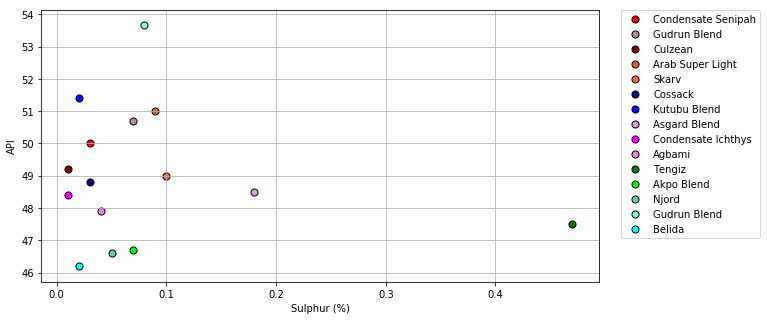

In [51]:
# Print results chart
chart = get_figures_mpl(df_result, quality_properties, kvalue)

On the chart above are plotted the sweeter and lighter crude oil grades contained in the analysed dataset. At least in terms of quality, we can say those are the 15 most expensive crude oil grades.

However, another layer of the analysis is required to fine tune this assessment. To have a more accurate conclusion, it is required to look at the historic and actual prices those grades are traded and make the final comparison. 

Unfortunately, price details are normally private, and even with some costly subscriptions that are necessary to use, public disclosure is very difficult to obtain.